Lambda School Data Science

*Unit 2, Sprint 3, Module 1*

---


# Define ML problems

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your decisions.

- [ ] Choose your target. Which column in your tabular dataset will you predict?
- [ ] Is your problem regression or classification?
- [ ] How is your target distributed?
    - Classification: How many classes? Are the classes imbalanced?
    - Regression: Is the target right-skewed? If so, you may want to log transform the target.
- [ ] Choose your evaluation metric(s).
    - Classification: Is your majority class frequency >= 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?
    - Regression: Will you use mean absolute error, root mean squared error, R^2, or other regression metrics?
- [ ] Choose which observations you will use to train, validate, and test your model.
    - Are some observations outliers? Will you exclude them?
    - Will you do a random split or a time-based split?
- [ ] Begin to clean and explore your data.
- [ ] Begin to choose which features, if any, to exclude. Would some features "leak" future information?

If you haven't found a dataset yet, do that today. [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2) and choose your dataset.

Some students worry, ***what if my model isn't “good”?*** Then, [produce a detailed tribute to your wrongness. That is science!](https://twitter.com/nathanwpyle/status/1176860147223867393)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install category_encoders==2.*

     |████████████████████████████████| 82 kB 367 kB/s 


In [314]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, plot_confusion_matrix, plot_roc_curve,roc_auc_score, mean_absolute_error

from sklearn.inspection import permutation_importance 
from xgboost import XGBClassifier 
from sklearn.metrics import plot_confusion_matrix, classification_report

In [4]:
%cd /content/drive/MyDrive/DATA SCHOOL FILES/LAMBDA/UNIT 2 (Predictive_Modeling)/Unit 2.3

/content/drive/MyDrive/DATA SCHOOL FILES/LAMBDA/UNIT 2 (Predictive_Modeling)/Unit 2.3


In [5]:
!ls

'Life Expectancy Data.csv'	 'Module 2 - Wrangling'
'Module 1 - Define ML Problems'  'Module 3'


In [296]:
def wrangle(DataFile):
  df = pd.read_csv(DataFile,
                  parse_dates=['Year']).set_index('Year')
  df.columns = df.columns.str.strip()
  df.drop(columns=['Measles','Population', 'HIV/AIDS','GDP','percentage expenditure'], inplace=True)#,'Total expenditure',
                   #'Life expectancy','under-five deaths','Polio','Diphtheria','Schooling']
  #df = df.loc[df['Life expectancy '].notnull()]
  return df

In [297]:
df = wrangle('Life Expectancy Data.csv')

In [298]:
df.head()

,Country,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,Hepatitis B,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
Year,,,,,,,,,,,,,,,,
2015-01-01,Afghanistan,Developing,65.0,263.0,62,0.01,65.0,19.1,83,6.0,8.16,65.0,17.2,17.3,0.479,10.1
2014-01-01,Afghanistan,Developing,59.9,271.0,64,0.01,62.0,18.6,86,58.0,8.18,62.0,17.5,17.5,0.476,10.0
2013-01-01,Afghanistan,Developing,59.9,268.0,66,0.01,64.0,18.1,89,62.0,8.13,64.0,17.7,17.7,0.470,9.9
2012-01-01,Afghanistan,Developing,59.5,272.0,69,0.01,67.0,17.6,93,67.0,8.52,67.0,17.9,18.0,0.463,9.8
2011-01-01,Afghanistan,Developing,59.2,275.0,71,0.01,68.0,17.2,97,68.0,7.87,68.0,18.2,18.2,0.454,9.5


In [299]:
df.shape

(2938, 16)

In [300]:
df.isnull().sum()

Country                              0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
Hepatitis B                        553
BMI                                 34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
thinness  1-19 years                34
thinness 5-9 years                  34
Income composition of resources    167
Schooling                          163
dtype: int64

In [301]:
df.nunique()

Country                             193
Status                                2
Life expectancy                     362
Adult Mortality                     425
infant deaths                       209
Alcohol                            1076
Hepatitis B                          87
BMI                                 608
under-five deaths                   252
Polio                                73
Total expenditure                   818
Diphtheria                           81
thinness  1-19 years                200
thinness 5-9 years                  207
Income composition of resources     625
Schooling                           173
dtype: int64

In [302]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2938 entries, 2015-01-01 to 2000-01-01
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Status                           2938 non-null   object 
 2   Life expectancy                  2928 non-null   float64
 3   Adult Mortality                  2928 non-null   float64
 4   infant deaths                    2938 non-null   int64  
 5   Alcohol                          2744 non-null   float64
 6   Hepatitis B                      2385 non-null   float64
 7   BMI                              2904 non-null   float64
 8   under-five deaths                2938 non-null   int64  
 9   Polio                            2919 non-null   float64
 10  Total expenditure                2712 non-null   float64
 11  Diphtheria                       2919 non-null   float64
 12  th

In [303]:
df['Status'].value_counts(normalize=True)

Developing    0.825732
Developed     0.174268
Name: Status, dtype: float64

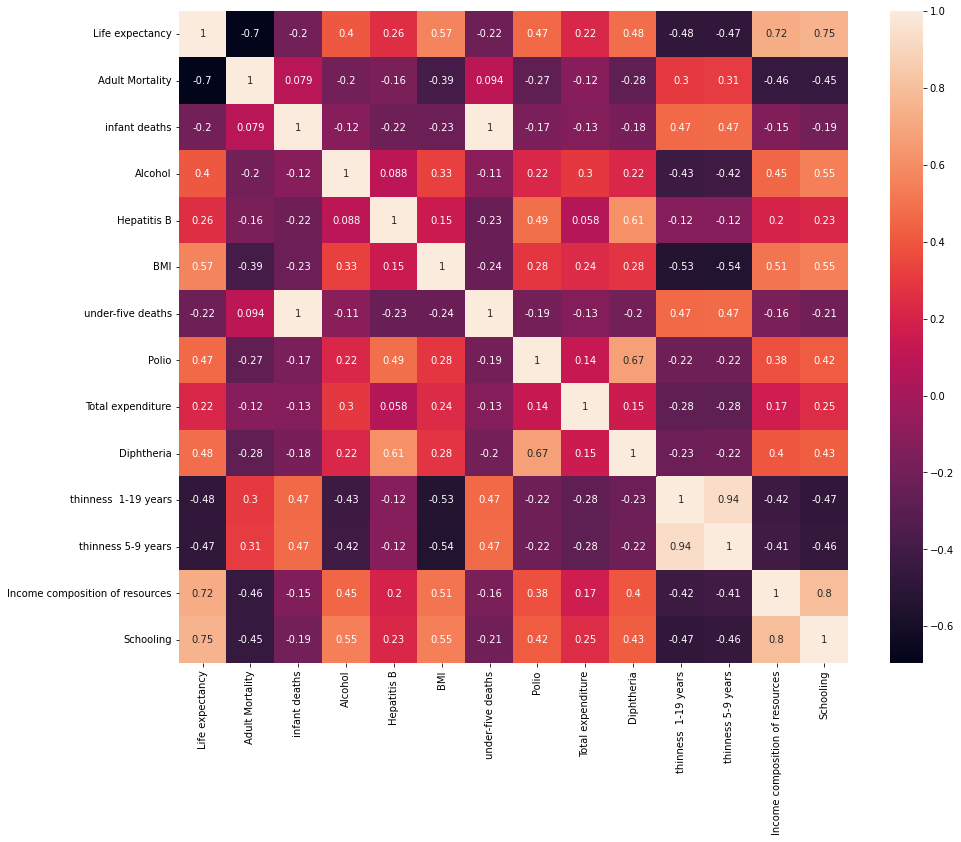

In [304]:
plt.figure(figsize=(15,12))
sns.heatmap(df.corr(), annot=True)

In [305]:
X = df.drop(columns=['Status','Country'])
y = df['Status']


mask_train = df.index < '2012'
mask_val = (df.index >= '2012') & (df.index <= '2013')
mask_test = (df.index >= '2014')

X_train = X.loc[mask_train]
y_train = y.loc[mask_train]

X_val = X.loc[mask_val]
y_val = y.loc[mask_val]

X_test = X.loc[mask_test]
y_test = y.loc[mask_test]

In [306]:
#Baseline 

pred_Status = y_train.value_counts(normalize=True).max()

print('Baseline Accuracy:', pred_Status )

Baseline Accuracy: 0.825136612021858


In [307]:
model = make_pipeline(
    #OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(#XGBClassifier(random_state=42,# n_estimators=18,max_depth=12,
                           random_state=42,
                           n_jobs=-1)

)

model.fit(X_train,y_train);

In [308]:
print('Train Accuracy:', model.score(X_train,y_train))
print()
print('Validation Accuracy:', model.score(X_val,y_val) )
print()
print('Test Accuracy:', model.score(X_test,y_test) )
#Test Accuracy: 0.9371584699453552      0.9426229508196722

Train Accuracy: 1.0

Validation Accuracy: 0.9920212765957447

Test Accuracy: 0.953551912568306


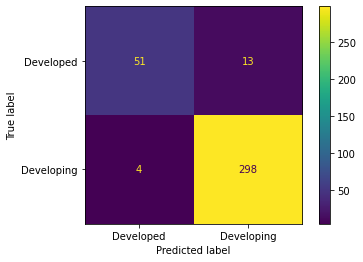

In [317]:
plot_confusion_matrix(
    model,
    X_test, # validation data
    y_test, # validation data
    values_format='.0f',
    display_labels=['Developed', 'Developing'] # classes/labels in sorted order
);

In [309]:
perm_importance = permutation_importance(model, X_val,y_val, random_state=42)

In [321]:
precision = 51/(51+13)
recall = 51/(51+4)
print('Presicion: ',precision)
print('Recall: ',recall)



Presicion:  0.796875
Recall:  0.9272727272727272


In [310]:
perm_importance

{'importances': array([[0.00797872, 0.00531915, 0.00797872, 0.0106383 , 0.01329787],
        [0.00797872, 0.00797872, 0.00797872, 0.00797872, 0.00531915],
        [0.00797872, 0.01329787, 0.00797872, 0.0106383 , 0.00797872],
        [0.04521277, 0.04521277, 0.05319149, 0.04787234, 0.04255319],
        [0.00531915, 0.00531915, 0.        , 0.00797872, 0.0106383 ],
        [0.        , 0.00531915, 0.        , 0.        , 0.00265957],
        [0.        , 0.00531915, 0.00531915, 0.00265957, 0.00265957],
        [0.00265957, 0.00531915, 0.00531915, 0.00265957, 0.00531915],
        [0.00531915, 0.00265957, 0.00797872, 0.00531915, 0.00797872],
        [0.00265957, 0.00797872, 0.00531915, 0.00797872, 0.00797872],
        [0.01595745, 0.01595745, 0.01329787, 0.00797872, 0.01595745],
        [0.00531915, 0.00531915, 0.00531915, 0.00531915, 0.00531915],
        [0.02659574, 0.01595745, 0.02659574, 0.0106383 , 0.0212766 ],
        [0.01595745, 0.01595745, 0.01861702, 0.01329787, 0.01861702]]),
 'i

In [311]:
perm_imp_data = {'imp_mean':perm_importance['importances_mean'],'imp_std':perm_importance['importances_std']} 

Importances = pd.DataFrame(perm_imp_data, index=X_val.columns)

In [312]:
Importances.sort_values(by='imp_mean',ascending=False)

,imp_mean,imp_std
Alcohol,0.046809,0.003608
Income composition of resources,0.020213,0.006203
Schooling,0.016489,0.001990
thinness 1-19 years,0.013830,0.003102
infant deaths,0.009574,0.002128
Life expectancy,0.009043,0.002712
Adult Mortality,0.007447,0.001064
Diphtheria,0.006383,0.002128
Hepatitis B,0.005851,0.003528
Total expenditure,0.005851,0.001990


In [322]:
df.groupby('Status')['Alcohol'].mean()

Status
Developed     9.826736
Developing    3.484119
Name: Alcohol, dtype: float64